# Machine Learning Spam Filter with NLP

### Introduction

In this script, I will be building a machine learning model that will fitler spam emails. This model will predict whether the email is spam or ham (not spam). I will also be using some Natural Language Processing for the cleaning process. The data we used are sample spam data downloaded from University of California Irvine database.

Sit back and Enjoy!

In [1]:
# import function
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

### Read data

In [2]:
df = pd.read_csv("SMSSpamCollection.tsv", sep='\t')
df.columns = ['label', 'body_text']
df.head()

,label,body_text
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,ham,"Nah I don't think he goes to usf, he lives aro..."
2,ham,Even my brother is not like to speak with me. ...
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
4,ham,As per your request 'Melle Melle (Oru Minnamin...


### Feature Engineering

Creating additional features to help predicting

In [3]:
def count_capital(text):
    count = sum(1 for char in text if char.isupper())
    return round(count/(len(text) - text.count(" ")), 3)*100

df['cap%'] = df['body_text'].apply(lambda x: count_capital(x))


def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

df['body_len'] = df['body_text'].apply(lambda x: len(x) - x.count(" "))
df['punct%'] = df['body_text'].apply(lambda x: count_punct(x))

df.head()

,label,body_text,cap%,body_len,punct%
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,7.8,128,4.7
1,ham,"Nah I don't think he goes to usf, he lives aro...",4.1,49,4.1
2,ham,Even my brother is not like to speak with me. ...,3.2,62,3.2
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,92.9,28,7.1
4,ham,As per your request 'Melle Melle (Oru Minnamin...,7.4,135,4.4


Checking how new features perform using some data exploration and data visualization

We can tell from the graph, both Capitalize % and the length of the email are pretty strong predictor for filtering. 

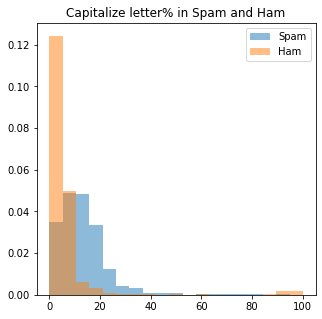

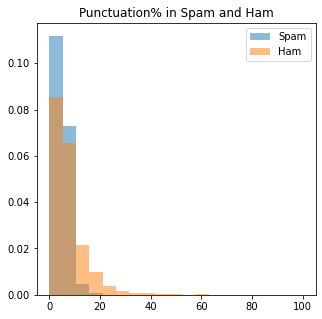

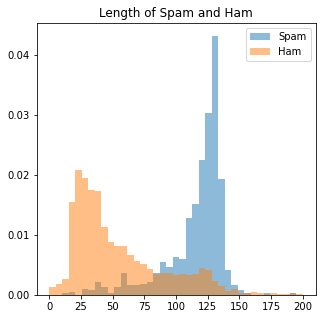

In [4]:
df_spam = df[df['label'] == 'spam']
df_ham = df[df['label'] == 'ham']

plt.figure(figsize=(5,5))
bins = np.linspace(0, 100, 20)
plt.hist(df_spam['cap%'], alpha = 0.5, bins = bins, density= True, label = 'Spam')
plt.hist(df_ham['cap%'], alpha = 0.5, bins = bins, density= True, label = 'Ham')
plt.title('Capitalize letter% in Spam and Ham')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
plt.hist(df_spam['punct%'], alpha = 0.5, bins = bins, density= True, label = 'Spam')
plt.hist(df_ham['punct%'], alpha = 0.5, bins = bins, density= True, label = 'Ham')
plt.title('Punctuation% in Spam and Ham')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
bins = np.linspace(0, 200, 40)
plt.hist(df_spam['body_len'], alpha = 0.5, bins = bins, density= True, label = 'Spam')
plt.hist(df_ham['body_len'], alpha = 0.5, bins = bins, density= True, label = 'Ham')
plt.title('Length of Spam and Ham')
plt.legend()
plt.show()


Create a function that will tokenize the word in each email and get rid of the punctuation and stopwords. Moreover, word that have the same meaning will be stem. 

For instance, "running" and "run" will be stem to "run". In this way, both "running" and "run" will be view as same word to the model.

In [5]:
ps = nltk.PorterStemmer()
stopwords = stopwords.words('english')

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

### Vectorizing the data

The reason why we split the data right now is to avoid data leakeage. 

I train TfidfVectorizer on training data, we vectorized a total of 7109 words from the data vs. 8106 vectorize when train on both training dataset and testing dataset. 

As a result, 8106 - 7109 = 997 word will not be used for training (prediction). This prevent data leakage and make it more realistic scenerio. 

In [6]:
# Test train split in order to avoid data leakeage
X_train, X_test, y_train, y_test = train_test_split(df[['body_text', 'cap%', 'body_len', 'punct%']], df['label'].astype('category').cat.codes, test_size = 0.2, random_state = 1)


tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf_fit = tfidf_vect.fit(X_train['body_text'])

# Used train result to transform both train and testing dataset, since we need them to be in the same vectorize format
X_tfidf_train = X_tfidf_fit.transform(X_train['body_text'])
X_tfidf_test = X_tfidf_fit.transform(X_test['body_text'])

# Change them to dataframe format
X_tfidf_train_feat = pd.DataFrame(X_tfidf_train.toarray())
X_tfidf_test_feat = pd.DataFrame(X_tfidf_test.toarray())

# parse column name to make it easier to understand
X_tfidf_train_feat.columns = X_tfidf_fit.get_feature_names()
X_tfidf_test_feat.columns = X_tfidf_fit.get_feature_names()

In [7]:
print(X_tfidf_train_feat.head())
print(X_tfidf_train_feat.shape)

     0  008704050406  0089mi  0121  01223585236  01223585334  0125698789   02  \
0  0.0           0.0     0.0   0.0          0.0          0.0         0.0  0.0   
1  0.0           0.0     0.0   0.0          0.0          0.0         0.0  0.0   
2  0.0           0.0     0.0   0.0          0.0          0.0         0.0  0.0   
3  0.0           0.0     0.0   0.0          0.0          0.0         0.0  0.0   
4  0.0           0.0     0.0   0.0          0.0          0.0         0.0  0.0   

   020603  0207  ...    »    é    ü  üll    –    ‘    ’    “    …  …thank  
0     0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
1     0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
2     0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
3     0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
4     0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  

[5 rows x 7109 columns]
(4453, 7109)


In [8]:
print(X_tfidf_test_feat.head())
print(X_tfidf_test_feat.shape)

     0  008704050406  0089mi  0121  01223585236  01223585334  0125698789   02  \
0  0.0           0.0     0.0   0.0          0.0          0.0         0.0  0.0   
1  0.0           0.0     0.0   0.0          0.0          0.0         0.0  0.0   
2  0.0           0.0     0.0   0.0          0.0          0.0         0.0  0.0   
3  0.0           0.0     0.0   0.0          0.0          0.0         0.0  0.0   
4  0.0           0.0     0.0   0.0          0.0          0.0         0.0  0.0   

   020603  0207  ...    »    é    ü  üll    –    ‘    ’    “    …  …thank  
0     0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
1     0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
2     0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
3     0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  
4     0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  

[5 rows x 7109 columns]
(1114, 7109)


In [9]:
X_train_feat_combine = pd.concat([X_train[['body_len', 'punct%', 'cap%']].reset_index(drop = True), X_tfidf_train_feat], axis=1)
X_test_feat_combine = pd.concat([X_test[['body_len', 'punct%', 'cap%']].reset_index(drop = True), X_tfidf_test_feat], axis=1)


print(X_train_feat_combine.head())
print(X_train_feat_combine.shape)

print(X_test_feat_combine.head())
print(X_test_feat_combine.shape)

   body_len  punct%  cap%    0  008704050406  0089mi  0121  01223585236  \
0        53     3.8   5.7  0.0           0.0     0.0   0.0          0.0   
1        51     7.8   2.0  0.0           0.0     0.0   0.0          0.0   
2        60     3.3   3.3  0.0           0.0     0.0   0.0          0.0   
3         5    40.0  60.0  0.0           0.0     0.0   0.0          0.0   
4        46    13.0   4.3  0.0           0.0     0.0   0.0          0.0   

   01223585334  0125698789  ...    »    é    ü  üll    –    ‘    ’    “    …  \
0          0.0         0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1          0.0         0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2          0.0         0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3          0.0         0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4          0.0         0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   …thank  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.

In [10]:
# to make our life easier assign the newly vectorize data back to X_train and X_test
X_train = X_train_feat_combine
X_test = X_test_feat_combine

### Model Building

In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [12]:
def evalation(y_pred,y_test): ### Fuction to evalate the model
    
    ## Calculate the confusion matrix
    print('confusion Matrix')
    print(confusion_matrix(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    ## Calculate and display accuracy
    accuracy = (tp + tn)/(tn + fp + fn + tp)
    false_postive = (fp)/(fp + tn)
    false_negative = fn / (fn + tp)
    
    #print(tn, fp, fn, tp)
    
    print('Accuracy:', round(accuracy*100, 4), '%.')
    print('Fasle Positive Rate', round(false_postive*100, 4), '%')
    print('Fasle Negative Rate', round(false_negative*100, 4), '%')
    
    print('Classification Report')
    print(classification_report(y_test, y_pred))
    
def roc_curve_eval(y_pred,y_test): ### Function to calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print('Roc Auc score: {}'.format(round(roc_auc,4)))
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    #fig.savefig('/tmp/roc.png')
    plt.show()
    

### Run model

RandomForest model

confusion Matrix
[[956   0]
 [ 24 134]]
Accuracy: 97.8456 %.
Fasle Positive Rate 0.0 %
Fasle Negative Rate 15.1899 %
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       956
           1       1.00      0.85      0.92       158

    accuracy                           0.98      1114
   macro avg       0.99      0.92      0.95      1114
weighted avg       0.98      0.98      0.98      1114

Roc Auc score: 0.9241


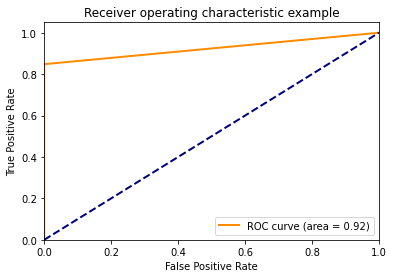

[(0.04968736047897116, 'body_len'),
 (0.037193449608890615, 'call'),
 (0.03510855758302826, 'cap%'),
 (0.026752457909083777, 'txt'),
 (0.02063440021168295, 'claim'),
 (0.020243325703427732, 'mobil'),
 (0.019366895475685937, 'free'),
 (0.01759329126971878, 'servic'),
 (0.015204440050685084, 'repli'),
 (0.014972235711712849, 'prize'),
 (0.012178935779427297, 'stop'),
 (0.011798708761811508, 'text'),
 (0.01057296704806503, 'tone'),
 (0.010471005409463125, 'punct%'),
 (0.010266810768152992, '18'),
 (0.010212811136068338, 'contact'),
 (0.010162086617599729, 'urgent'),
 (0.009065712134146827, 'custom'),
 (0.00810992299223528, 'win'),
 (0.006870485719270919, 'per'),
 (0.006682650476287882, '16'),
 (0.006585935093808587, 'tc'),
 (0.0063802507802888375, 'nokia'),
 (0.005696111002904419, 'voucher'),
 (0.005651196836670997, 'select')]

In [14]:
### select model to use
clf = RandomForestClassifier(random_state=1)

### fit the model
clf.fit(X_train, y_train)

### predict
y_pred = clf.predict(X_test)

### evaluate performance
evalation(y_pred,y_test)
roc_curve_eval(y_pred,y_test)

### Show top 25 most important features
sorted(zip(clf.feature_importances_, X_train.columns), reverse = True)[:25]

XGboost model

confusion Matrix
[[949   7]
 [ 13 145]]
Accuracy: 98.2047 %.
Fasle Positive Rate 0.7322 %
Fasle Negative Rate 8.2278 %
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       956
           1       0.95      0.92      0.94       158

    accuracy                           0.98      1114
   macro avg       0.97      0.96      0.96      1114
weighted avg       0.98      0.98      0.98      1114

Roc Auc score: 0.9552


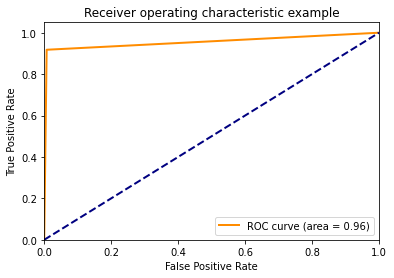

[(0.056700703, 'smile'),
 (0.035494264, '18'),
 (0.032840002, 'body_len'),
 (0.032061063, 'claim'),
 (0.03058447, 'network'),
 (0.027253231, 'servic'),
 (0.025991885, 'give'),
 (0.025455706, 'rington'),
 (0.023610294, 'love'),
 (0.022449445, 'txt'),
 (0.021942273, 'rate'),
 (0.021611223, 'stop'),
 (0.021318553, 'call'),
 (0.019792318, 'tone'),
 (0.017024571, 'deliveri'),
 (0.014851605, 'cap%'),
 (0.0147029245, 'admir'),
 (0.014469977, '1'),
 (0.013738533, 'feel'),
 (0.013668052, 'appli'),
 (0.013130428, 'user'),
 (0.012878574, 'problem'),
 (0.01284278, 'chat'),
 (0.012355256, 'text'),
 (0.011941185, 'mobil')]

In [15]:
### select model to use
clf = XGBClassifier(random_state=1)

### fit the model
clf.fit(X_train, y_train)

### predict
y_pred = clf.predict(X_test)

### evaluate performance
evalation(y_pred,y_test)
roc_curve_eval(y_pred,y_test)

### Show top 25 most important features
sorted(zip(clf.feature_importances_, X_train.columns), reverse = True)[:25]

### Grid Search both model to find the best parameter

In [301]:
rf = RandomForestClassifier()
param = {
   'n_estimators': [10, 150, 300],
    'max_depth': [30, 60, 90, None],
}

clf = GridSearchCV(rf, param, cv=5, n_jobs=-1)
cv_fit = clf.fit(X_train, y_train)
pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,24.316589,2.380649,0.495197,0.143792,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.979798,0.969697,0.977553,0.976404,0.971910,0.975073,0.003719,1
8,37.177193,0.502629,0.641896,0.245299,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.978676,0.969697,0.980920,0.975281,0.970787,0.975072,0.004347,2
11,28.347910,0.439215,0.324996,0.054405,None,300,"{'max_depth': None, 'n_estimators': 300}",0.979798,0.969697,0.978676,0.973034,0.971910,0.974623,0.003933,3
4,17.264466,0.365687,0.305060,0.051943,60,150,"{'max_depth': 60, 'n_estimators': 150}",0.977553,0.966330,0.980920,0.974157,0.971910,0.974174,0.004972,4
10,18.032146,1.441127,0.363781,0.089173,None,150,"{'max_depth': None, 'n_estimators': 150}",0.976431,0.967452,0.979798,0.974157,0.969663,0.973500,0.004472,5


In [305]:
xgbclass = XGBClassifier()
param = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [7, 11, 15],
    'learning_rate': [0.1]
}

clf = GridSearchCV(xgbclass, param, cv=5)
cv_fit = clf.fit(X_train, y_train)
pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,83.370846,1.188813,0.383596,0.020233,0.1,11,150,"{'learning_rate': 0.1, 'max_depth': 11, 'n_est...",0.974186,0.969697,0.973064,0.978652,0.971910,0.973502,0.002973,1
4,56.875007,0.661627,0.366480,0.004779,0.1,11,100,"{'learning_rate': 0.1, 'max_depth': 11, 'n_est...",0.971942,0.969697,0.974186,0.975281,0.973034,0.972828,0.001923,2
2,57.566587,2.493364,0.379380,0.016481,0.1,7,150,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.974186,0.970819,0.974186,0.973034,0.970787,0.972602,0.001528,3
8,106.773492,12.869905,0.413223,0.017310,0.1,15,150,"{'learning_rate': 0.1, 'max_depth': 15, 'n_est...",0.974186,0.968575,0.971942,0.976404,0.970787,0.972379,0.002708,4
7,69.113906,0.481338,0.364668,0.009497,0.1,15,100,"{'learning_rate': 0.1, 'max_depth': 15, 'n_est...",0.973064,0.968575,0.971942,0.975281,0.970787,0.971930,0.002240,5


### Final model and evaluation

confusion Matrix
[[956   0]
 [ 22 136]]
Accuracy: 98.0251 %.
Fasle Positive Rate 0.0 %
Fasle Negative Rate 13.9241 %
Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       956
           1       1.00      0.86      0.93       158

    accuracy                           0.98      1114
   macro avg       0.99      0.93      0.96      1114
weighted avg       0.98      0.98      0.98      1114

Roc Auc score: 0.9304


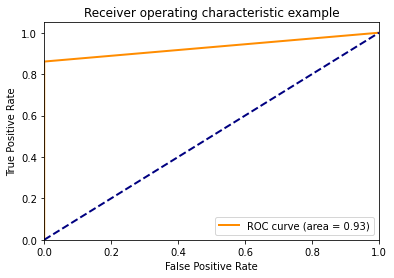

In [16]:
### select model to use
clf = RandomForestClassifier(random_state=1, n_estimators = 150, max_depth = 90)

### fit the model
clf.fit(X_train, y_train)

### predict
y_pred = clf.predict(X_test)

### evaluate performance
evalation(y_pred,y_test)
roc_curve_eval(y_pred,y_test)

confusion Matrix
[[947   9]
 [ 12 146]]
Accuracy: 98.1149 %.
Fasle Positive Rate 0.9414 %
Fasle Negative Rate 7.5949 %
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       956
           1       0.94      0.92      0.93       158

    accuracy                           0.98      1114
   macro avg       0.96      0.96      0.96      1114
weighted avg       0.98      0.98      0.98      1114

Roc Auc score: 0.9573


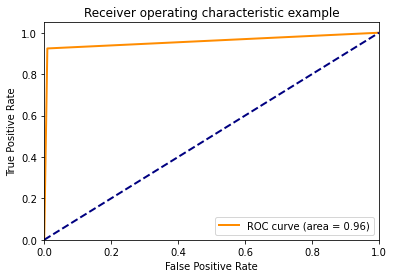

In [17]:
### select model to use
clf = XGBClassifier(random_state=1,n_estimators=150, max_depth=11, learning_rate = 0.1)

### fit the model
clf.fit(X_train, y_train)

### predict
y_pred = clf.predict(X_test)

### evaluate performance
evalation(y_pred,y_test)
roc_curve_eval(y_pred,y_test)

### Summary

Although XGboost model has slightly higher accuracy than random forest model, we need to think about what we are trying to predict. In this case, we are trying to predict whether email are legitimate email or spam email. In the nature of email, we care more about if the legitimate email is accidentally classified as spam. This will create a huge headache for people, since they would possibly missed important email that was accidentally put in the spam folder.

In other words, we care more about the False Positive than the False Negative in a spam filter model. Hence, the Random forest model will be a better model with 0% False Positive and 100 % precision. This means all email that was classified as spam by random forest are all spam.

Even though, the Fasle Negative Rate of Random Forest model are a two times higher than Xgboost model, it should not be too much of a issue, since False Positive Rate are greater concern than False Negative Rate for a Spam Filter. 